# Notebook de départ

Ce notebook est un point de départ qui vous montre la base de comment accéder aux données et en extraire la distribution de la pseudo-rapidité $\eta$ des traces.

## Importation de modules python

La plupart des notebooks jupyter commencent par une liste d'importation de modules python qui sont ensuite utilisés.
Dans ce projet les modules de base sont : 
- [uproot](https://uproot.readthedocs.io/en/latest/) pour lire (et écrire) des données au format [ROOT](https://root.cern.ch) (mais sans avoir besoin d'installer ROOT)
- [awkward](https://awkward-array.readthedocs.io/en/latest/) pour manipuler des tableaux avec des structures de taille variable (qui sont ce que l'on utilise couramment en physique des hautes énergies, e.g. chaque événement contient potentiellement un nombre différent de muons)
- [numpy](https://numpy.org) qui est la base de la base des modules de "scientific computing" dans le monde Python. Un peu moins nécessaire dans notre cas (les awkward arrays sont généralement plus adaptés) mais certainement un module à connaître et à explorer dans votre future carrière.
- [matplotlib](https://matplotlib.org) pour créer de nombreux types de visualisations

Pour apprendre et pratiquer ces modules, voir par exemple un [tutorial récent](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial/blob/main/tutorial.ipynb)


In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
print("uproot version",uproot.__version__)
print("awkward version",ak.__version__)
print("numpy version",np.__version__)
print("matplotlib version",matplotlib.__version__)

uproot version 4.1.8
awkward version 1.5.1
numpy version 1.21.4
matplotlib version 3.4.3


## Récupération des données

Ensuite il faut récupérer, d'une façon ou d'une autre, les données que l'on veut analyser/explorer/visualiser. Dans cet exemple, on copie simplement un fichier ROOT depuis CERNBox (équivalent CERN de services comme DropBox, OneDrive, etc...) vers l'ordinateur qui tourne ce notebook.

In [8]:
!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=290223/AnalysisResults.root' > run290223.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3602k  100 3602k    0     0  4796k      0 --:--:-- --:--:-- --:--:-- 4789k


## Exploration rapide des données (i.e. le format des données)

In [9]:
file = uproot.open("run290223.data.root")

In [10]:
file.keys()

['eventsTree;1']

In [34]:
events = file["eventsTree"]
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Py              

L'idée est ensuite de mettre les variables d'intérêt dans des tableaux que l'on manipulera ensuite. Par exemple on récupère ci-dessous des tableaux contenant le nombre de traces par événement, les composantes x,y,z de l'impulsion des traces et leur charge; et ceci pour les 10000 premiers événements (pour que le reste de ce notebook d'exemple ne soit pas trop lent). 

In [45]:
m = events.arrays(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",entry_stop=10000)
type(m)

awkward.highlevel.Array

Ce tableau peut être indexé de différentes façons. Avec un index unique pour accéder un seul élément : 

In [56]:
m[18].to_list()

{'nMuons': 1,
 'Muon': [{'Px': -0.5483500957489014,
   'Py': -0.22255341708660126,
   'Pz': -6.712076663970947,
   'Charge': -1}]}

> Challenge : l'index 18 correspond en fait au premier événement qui a au moins un muon dans cet échantillon de données. Comment trouver cet index rapidement ? 

Un index négatif est relatif à la fin du tableau. Le dernier événement est : 

In [57]:
m[-1].to_list()

{'nMuons': 0, 'Muon': []}

L'index peut également décrire un intervalle, e.g. pour afficher les 3 premiers événements :  

In [58]:
m[0:3].to_list()

[{'nMuons': 0, 'Muon': []},
 {'nMuons': 0, 'Muon': []},
 {'nMuons': 0, 'Muon': []}]

Un index peut également être un tableau de booléen où les valeurs à True indiquent les valeurs à indexer. Par exemple pour afficher le premier événement qui possède au moins 2 muons :

In [59]:
m[m.nMuons>1][0].to_list()

{'nMuons': 2,
 'Muon': [{'Px': -0.019152436405420303,
   'Py': -1.2657990455627441,
   'Pz': -32.36643981933594,
   'Charge': 1},
  {'Px': -0.7412209510803223,
   'Py': 0.275270938873291,
   'Pz': -16.64299774169922,
   'Charge': 1}]}

## Calcul de la pseudo-rapidité 

Définissons maintenant quelques fonctions pour calculer la pseudo-rapidité $\eta$ d'un tri-vecteur... 

In [60]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz);
    return 1.0 if ptot == 0.0 else pz/ptot

def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log( (1.0-ct)/(1.0+ct) )
    if pz == 0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20


... et leur application à un objet muon : 

In [61]:
def Eta(Muon):
    """Returns the pseudo-rapidity of the first element of the Muon vector.

Note that Muon[0] must have Px,Py,Pz attributes for this to work    
    """
    
    px = Muon[0].Px
    py = Muon[0].Py
    pz = Muon[0].Pz
    return eta(px,py,pz)

print(Eta.__doc__)
    

Returns the pseudo-rapidity of the first element of the Muon vector.

Note that Muon[0] must have Px,Py,Pz attributes for this to work    
    


> A noter qu'en règle générale, opérer sur un seul objet est assez peu performant et la plupart des libraries scientifiques Python (numpy en premier lieu) essayent au contraire d'opérer sur des tableaux d'objets/de valeurs afin d'être (bien) plus efficace. C'est ce que l'on appelle "vectoriser". Mais pour démarrer, il est sans doute plus simple de raisonner objet par objet. 

Enfin on créé un tableau des valeurs de $\eta$ pour tous les muons (notez que l'on sélectionne les événements qui ont au moins un muon)
> exercice: que se passe-t'il si l'on enlève la condition sur le nombre de muons ? 

In [62]:
etas = np.array([Eta(muon) for muon in m[m.nMuons>0]["Muon"]])

## Visualisation de la pseudo-rapidité des muons

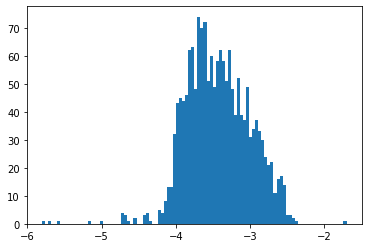

In [63]:
plt.hist(etas,bins=100);

La librarie [matplotlib](https://matplotlib.org) permet bien entendu de peaufiner cette figure autant que l'on souhaite... Par exemple en spécifiant un titre, en nommant les axes et en ajoutant une légende.

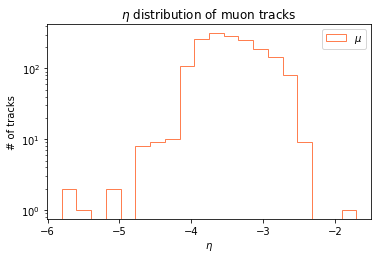

In [64]:
fig = plt.figure(figsize=(5,3))
axes = fig.add_axes([0.1,0.1,0.9,0.9])
axes.set_title("$\eta$ distribution of muon tracks")
axes.set_xlabel("$\eta$")
axes.set_ylabel("# of tracks")
axes.set_yscale("log")
axes.hist(etas,bins=20,label="$\mu$",color='coral',histtype='step');
axes.legend();


## Exercices conseillés

Afin de vous familiariser avec les outils, essayez maintenant de faire un plot de l'impulsion transverse des muons. 

Puis, sur un même plot, tracer séparemment les $\mu^+$ et les $\mu^-$.

Enfin, observez la distribution du nombre de muons par événement et attaquez vous aux caractéristiques des paires de muons (masse invariante, impulsion transverse, rapidité, ...) !

(array([8.32e+03, 1.59e+03, 8.70e+01, 3.00e+00, 0.00e+00]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

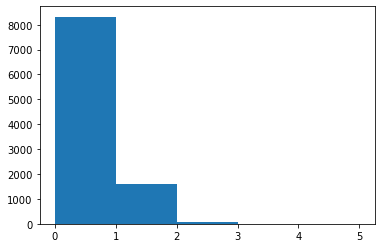

In [65]:
plt.hist(m.nMuons,bins=[0,1,2,3,4,5])

In [66]:
print("Nombre total d'événements: {}".format(len(m)))
print("Nombre d'événements avec au moins deux muons: {}".format(len(m[m.nMuons>1])))

Nombre total d'événements: 10000
Nombre d'événements avec au moins deux muons: 90
